It is basic data analyses, namely getting means and sums of different statistics such as average number of words per message per user and eventually evolved into analyzing topics that were frequently discussed in the group chat. 

One interesting analysis is using TF-IDF as a way to extract words that characterize each person in the group chat. It is interesting to see which words are often used by one person, but rarely by all others. 

## <a name="table">Table of Contents</a> 

1. [Functions](#functions)

2. [General Statistics](#general)  

    2.1 [Prepare Data](#gs-data)  
        
    2.2 [Users in the Group](#users)
    
    2.3 [Messages over time](#gs-messages)  
    
    2.4 [Active Moments](#gs-active) 
    
    2.5 [Averages / Summaries](#gs-averages) 
    
    2.6 [Response Time](#gs-response) 
    
3. [TF-IDF](#tfidf)  

    3.1 [Count Vector](#tf-count)  

    3.2 [Unique Words](#tf-unique)  

    3.3 [Plot Image](#tf-image)  

4. [Emoji Analysis](#emoji)  

    4.1 [Prepare Data](#emoji-prepare)  

    4.2 [Unique and Common Emojis](#emoji-stats)  

    4.3 [Correlation Matrix](#emoji-corr)  
    
5. [Topic Modelling](#topic)  

    5.1 [Prepare Data](#topic-prepare)  

    5.2 [LDA](#topic-lda)  

    5.3 [NMF](#topic-nmf)  
    
6. [Sentiment Analysis](#sentiment)  

    6.1 [Prepare Data](#sentiment-prepare)  

    6.2 [Average Sentiment](#sentiment-average)  
    
    6.3 [Plot Sentiment](#sentiment-plot)  
    
7. [Word Clouds](#cloud)  

    7.1 [Prepare Data](#cloud-prepare)  

    7.2 [Masked Word Cloud](#cloud-mask)  

    7.3 [Sentiment-based Word Cloud](#cloud-sentiment) 
    
8. [Color Analysis](#color)  

    8.1 [Extract Frequent Colors (k-Means)](#color-get)  

    8.2 [Plot Frequent Colors](#color-plot)  

## <a name="functions">1. Functions</a> 
[Back to Table of Contents](#table)

In [1]:
# Ubuntu
!cd soan_master/whatsapp
!find . -name '*.pyc' -delete

In [2]:
import json
import matplotlib.pyplot as plt
import nltk
import os

from collections import Counter
from dateutil.parser import parse
from time import time
import importlib # The imp module was deprecated in Python 3.4 in favor of the importlib module.

%matplotlib inline

In [66]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/ashish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ashish/nltk_data...


KeyboardInterrupt: 

In [3]:
from soan_master.whatsapp.scripts import import_data_script as ids
from soan_master.whatsapp.scripts import preprocess_data_script as pds
from soan_master.whatsapp.scripts import number_of_words_script as nows

In [4]:
from soan_master.whatsapp import helper      # Helper to prepare the data
from soan_master.whatsapp import general     # General statistics
from soan_master.whatsapp import tf_idf      # To calculate TF-IDF 

In [5]:
from soan_master.whatsapp import sentiment   # Sentiment Analysis
from soan_master.colors import colors        # Frequent Color Visualization
from soan_master.whatsapp import soan_emoji  # To analyze emoji use # Dependency: pip install emoji regex seaborn

# Error you get while trying to import the emoji.py as is. 
# ImportError: cannot import name emoji
# Solution: You need to rename it to something else like "soan_emoji.py"

In [6]:
importlib.reload(general)
importlib.reload(tf_idf)
importlib.reload(soan_emoji)
importlib.reload(ids)
importlib.reload(pds)
importlib.reload(nows)

<module 'soan_master.whatsapp.scripts.number_of_words_script' from '/home/ashish/Desktop/ws/gh/public/pubML/e10_whatsapp_soan/soan_master/whatsapp/scripts/number_of_words_script.py'>

## <a name="general">2. General Statistics</a> 

Here you can find general data with regards to whatsapp conversations such as the number of messages and words. 

#### <a name="gs-data">2.1 Prepare Data</a> 

The data is preprocessed by loading in the raw txt file which is sent through whatsapp to your mail. The following columns are created:
* Message_Raw
    * The raw message for each user (including date and name of user)
* User
    * The user who has sent the message, if no users have sent that message
    then it is simply removed from the dataframe
* Message_Clean
    * Only containing the message, but with all possible symbols in there
    Thus, no date and no name of the user
* Message_Only_Text
    * Only text, lowercase
* Date
    * Date in the format y/m/d

In [7]:
#df = helper.import_data('WhatsApp Chat with FSADM Team.txt')
#df = helper.import_data('WhatsApp Chat with Cousins (201910-201912).txt')
#df = helper.import_data('files_1/WhatsApp Chat with BITS Lounge (20200117).txt')

In [8]:
# input_text_file = os.listdir('files_1/file_output')[-1]
input_text_file = "WhatsApp Chat with Mapsko Mountville Family.txt"
directory_path = "MMV/20230114 0610"
df = ids.import_data(input_text_file, directory_path)

In [9]:
print("By default, we have picked the latest file: ", input_text_file)

By default, we have picked the latest file:  WhatsApp Chat with Mapsko Mountville Family.txt


In [10]:
c = Counter(df['User'])
mc = c.most_common()

In [11]:
mc[:20]

[('+91 99994 80107', 201),
 ('+91 72763 03938', 181),
 ('Ankit Malik H2502 Mountville GGM', 171),
 ('+91 99998 21063', 119),
 ('+91 88027 71414', 109),
 ('+91 88008 16147', 103),
 ('Harsh Sharma MMV', 102),
 ('+91 82917 66046', 98),
 ('+91 95607 77552', 97),
 ('+91 99100 77054', 91),
 ('+91 70228 88847', 88),
 ('+91 98719 89782', 85),
 ('+91 84477 31434', 64),
 ('+91 98112 62620', 60),
 ('+91 95400 96333', 58),
 ('+91 99998 80794', 56),
 ('+91 88007 62986', 54),
 ('+91 99963 76383', 50),
 ('+91 98182 50395', 49),
 ('+91 83908 60077', 46)]

In [12]:
users = []
msg_counts = []
percentages = []
for i in mc:
    users.append(i[0])
    msg_counts.append(i[1])
    percentages.append(round((float(i[1]) / df.shape[0]) * 100, 2))

In [13]:
u = users[0:19]
m = msg_counts[0:19]
p = percentages[0:19]
u.append('Others')
m.append(df.shape[0] - sum(m))
p.append(100 - sum(p))

In [14]:
# Generating hexadecimal RGB values for colors codes
decimals = [240, 196, 25, 37, 92, 97, 120, 144, 156, 106, 212, 207, 23, 174, 232, 92, 107, 192, 68, 75, 110, 239, 76, 96, 116, 69, 147, 238, 86, 145, 156, 204, 101, 112, 139, 117, 209, 203, 101, 13, 141, 225, 164, 85, 75, 105, 79, 93, 69, 173, 179, 38, 166, 154, 189, 199, 204]

for i in range(0, len(decimals), 3):
    pass
    #print(str(decimals[i]) + " " + str(decimals[i+1]) + " "+ str(decimals[i+2]))
    #print("'#" + hex(decimals[i])[2:] + hex(decimals[i+1])[2:] + hex(decimals[i+2])[2:] + "', ")

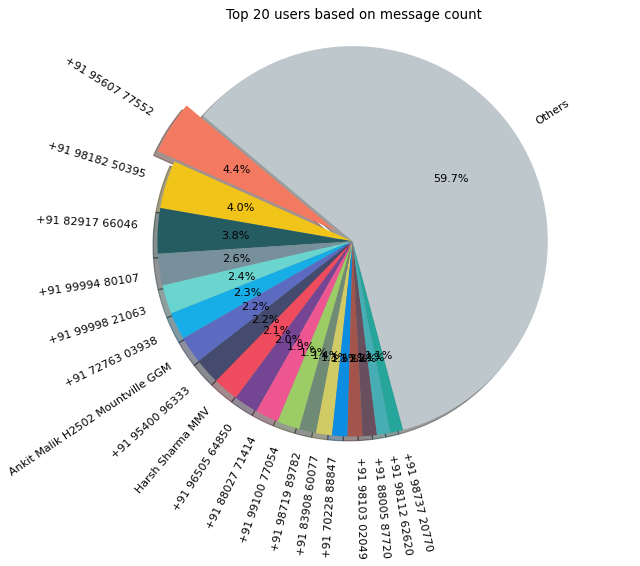

In [21]:
# Data to plot
#labels = [user.split(' ')[0] for user in u]
labels = [user for user in u]

sizes = m
colors = ['#f47961', '#f0c419', '#255c61', '#78909c', '#6ad4cf', '#17aee8', '#5c6bc0', '#444b6e', '#ef4c60', '#744593', '#ee5691', '#9ccc65', '#708b75', '#d1cb65', '#0d8de1', '#a4554b', '#694f5d', '#45adb3', '#26a69a', '#bdc7cc', ]
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)  # explode 1st slice

# Plot
plt.figure(num=None, figsize=(9, 7), dpi=80, facecolor='w', edgecolor='k')
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140, rotatelabels=True)
plt.title("Top 20 users based on message count")
          
plt.axis('equal')

plt.show()

In [22]:
df = pds.preprocess_data(df = df)

In [23]:
number_of_words_for_users = nows.get_number_of_words(df)
users_ranked_based_on_word_count = sorted(number_of_words_for_users, key=number_of_words_for_users.get, reverse=True)

users = []
word_counts = []
percentages = []
total_words = sum(number_of_words_for_users.values())

for i in users_ranked_based_on_word_count:
    users.append(i)
    word_counts.append(number_of_words_for_users[i])
    percentages.append(round((float(number_of_words_for_users[i]) / total_words) * 100, 2))
    
u = users[0:19]
wc = word_counts[0:19]
p = percentages[0:19]
u.append('Others')
wc.append(sum(word_counts) - sum(m))
p.append(100 - sum(p))

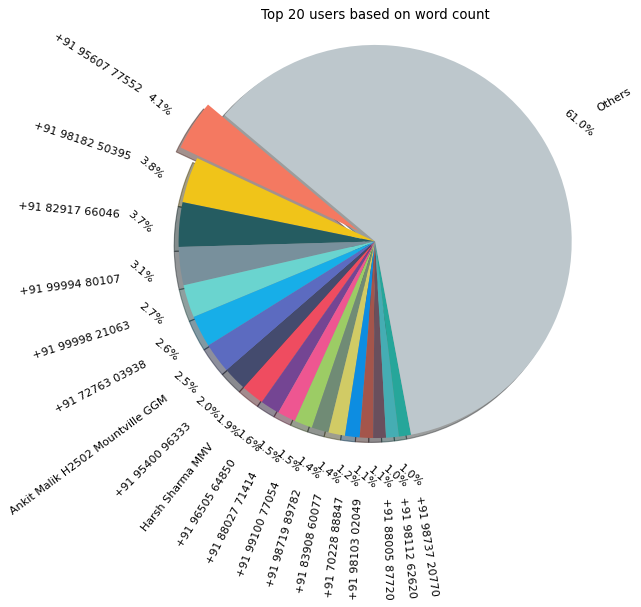

In [24]:
# Data to plot
labels = [user.split(' ')[0] for user in u]
labels = u
sizes = wc
colors = ['#f47961', '#f0c419', '#255c61', '#78909c', '#6ad4cf', '#17aee8', '#5c6bc0', '#444b6e', '#ef4c60', '#744593', '#ee5691', '#9ccc65', '#708b75', '#d1cb65', '#0d8de1', '#a4554b', '#694f5d', '#45adb3', '#26a69a', '#bdc7cc', ]
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)  # explode 1st slice

# Plot
plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')

w,l,p = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140, 
        rotatelabels=True, pctdistance=1.2, labeldistance=1.3)
[t.set_rotation(320) for t in p] # For rotation of percentages texts

plt.title("Top 20 users based on word count", y=1)
          
plt.axis('equal')

plt.show()

In [25]:
df['User'] = df.apply(lambda row: ''.join([i if ord(i) < 128 else '' for i in row.User]), axis = 1)
# Removing emoticons from name
# This LOC is not working from Python file and is hence commented there.
# File 'D:\workspace\Jupyter\exp_45.2_whatsapp\soan_master\whatsapp\helper.py'

In [26]:
# Change labels for anonymization 
#user_labels = {old: new for old, new in zip(sorted(df.User.unique()), ['Her', 'Me'])}
#df.User = df.User.map(user_labels)

In [27]:
df['Only_Date'] = df['Timestamp'].apply(lambda x: parse(x, dayfirst = True).isoformat().split('T')[0])

In [28]:
month_map ={
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}

In [29]:
df['Week_num'] = df['Timestamp'].apply(lambda x: parse(x, dayfirst = True).isocalendar()[1])
df['Year'] = df['Timestamp'].apply(lambda x: parse(x, dayfirst = True).isocalendar()[0])

df['week_num_and_year_num'] = df['Timestamp'].apply(lambda x: int(str(parse(x, dayfirst = True).isocalendar()[0]) + str(parse(x, dayfirst = True).isocalendar()[1])))

In [30]:
df['week_num_and_year_str'] = df['Timestamp'].apply(lambda x: str(parse(x, dayfirst = True).isocalendar()[0]) 
                                                    + '-' + str(parse(x, dayfirst = True).isocalendar()[1]))

In [31]:
temp_dict = dict(Counter(df.week_num_and_year_str.values))

Text(0, 0.5, 'Number of messages')

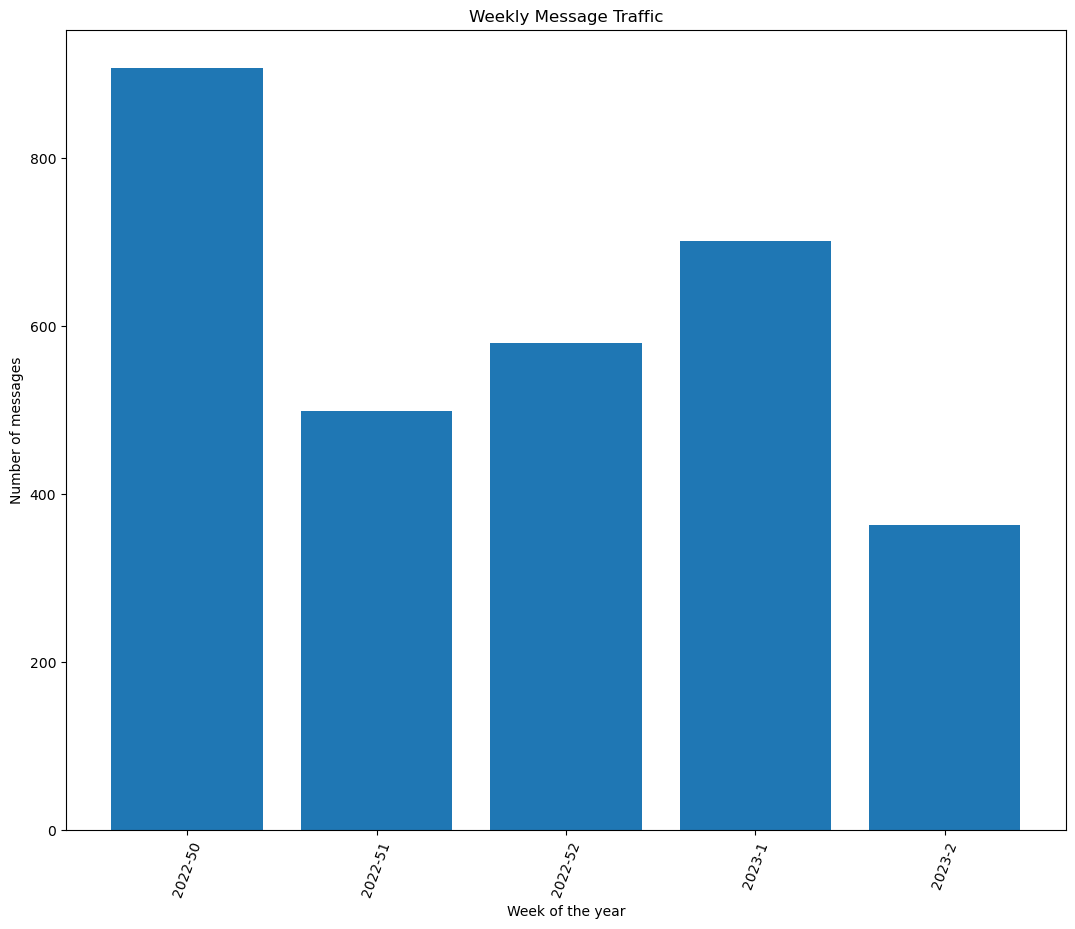

In [32]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_axes([0,0,1,1])

ax.bar(temp_dict.keys(), temp_dict.values())
plt.xticks(rotation=70)
plt.title('Weekly Message Traffic')
plt.xlabel('Week of the year')
plt.ylabel('Number of messages')

In [33]:
l = []
for i in temp_dict.values():
    if len(l) == 0:
        l.append(i)
    else:
        l.append(l[-1] + i)

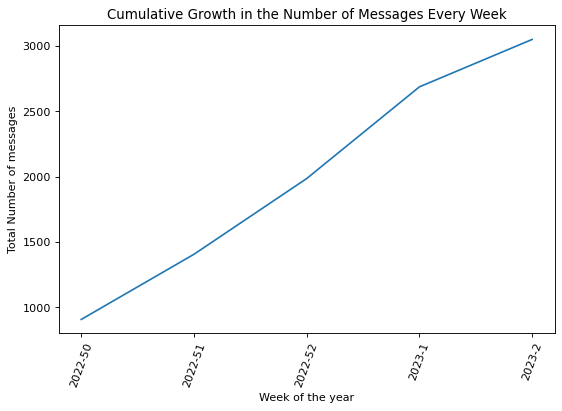

In [34]:
plt.figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=70)
plt.title('Cumulative Growth in the Number of Messages Every Week')
plt.xlabel('Week of the year')
plt.ylabel('Total Number of messages')
plt.plot(temp_dict.keys(), l)

In [35]:
#df.groupby('week_num_and_year').size().reset_index()

#### <a name="users">2.2 Users in the group</a> 

In [36]:
sorted(list(set(df.User)))[:5]

['+91 70228 88847',
 '+91 70301 19007',
 '+91 72763 03938',
 '+91 77188 77606',
 '+91 80108 90415']

#### <a name="gs-messages">2.3 Messages over time</a> 

ConversionError: Failed to convert value(s) to axis units: ['Jan \n2023', 'Dec \n2022']

findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


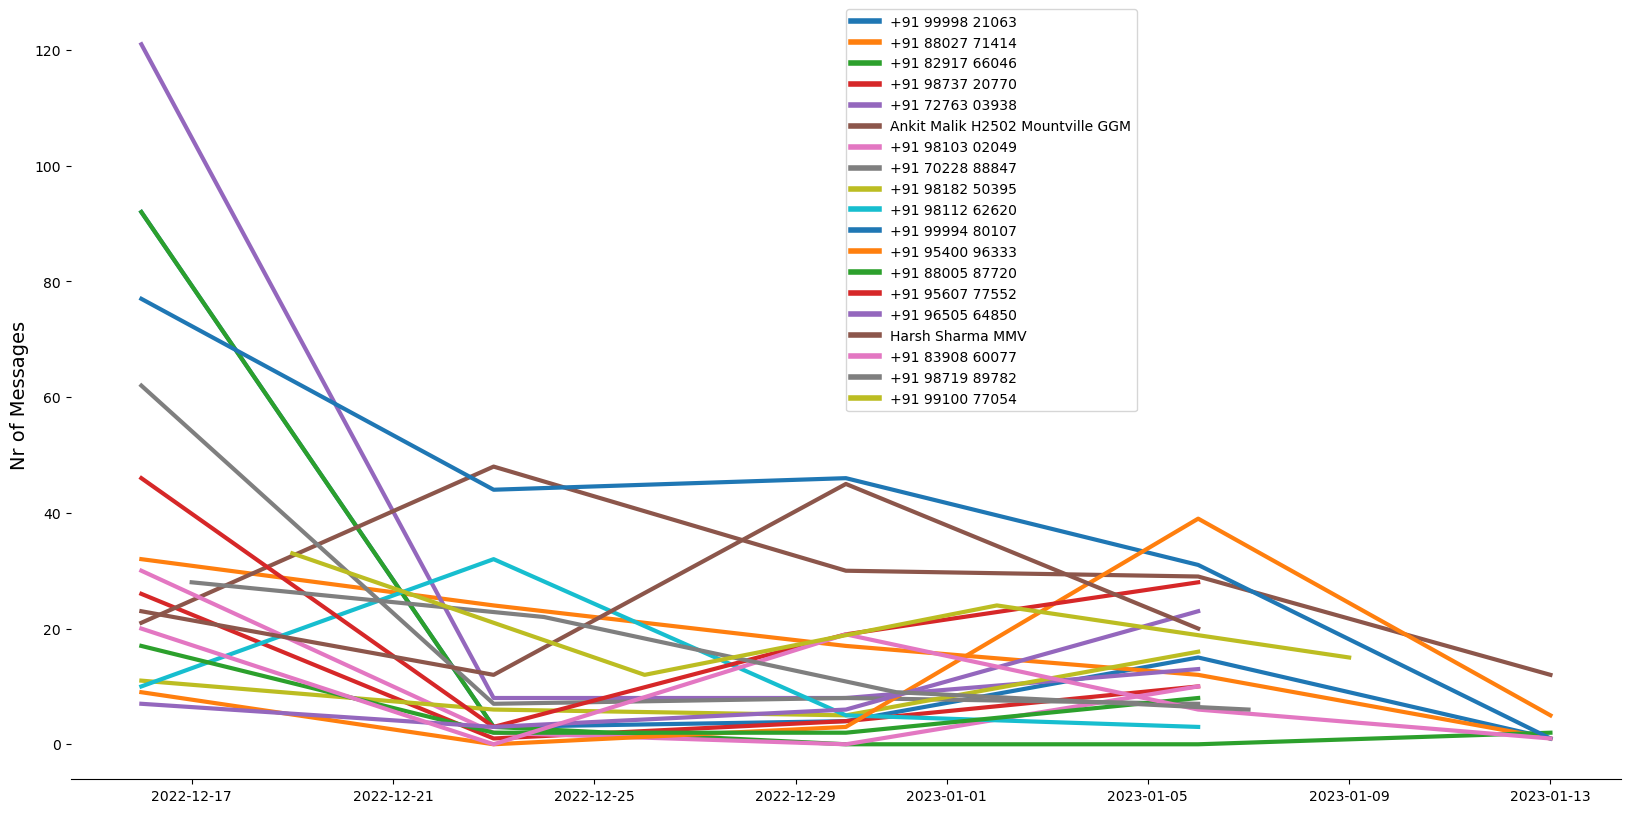

In [37]:
from dateutil.parser import parse
general.plot_messages(df[df.User.isin(u) & (df.Date > parse('1-Dec-2019'))], colors=None, trendline=False, savefig=False, dpi=100)

ConversionError: Failed to convert value(s) to axis units: ['Jan \n2023', 'Dec \n2022']

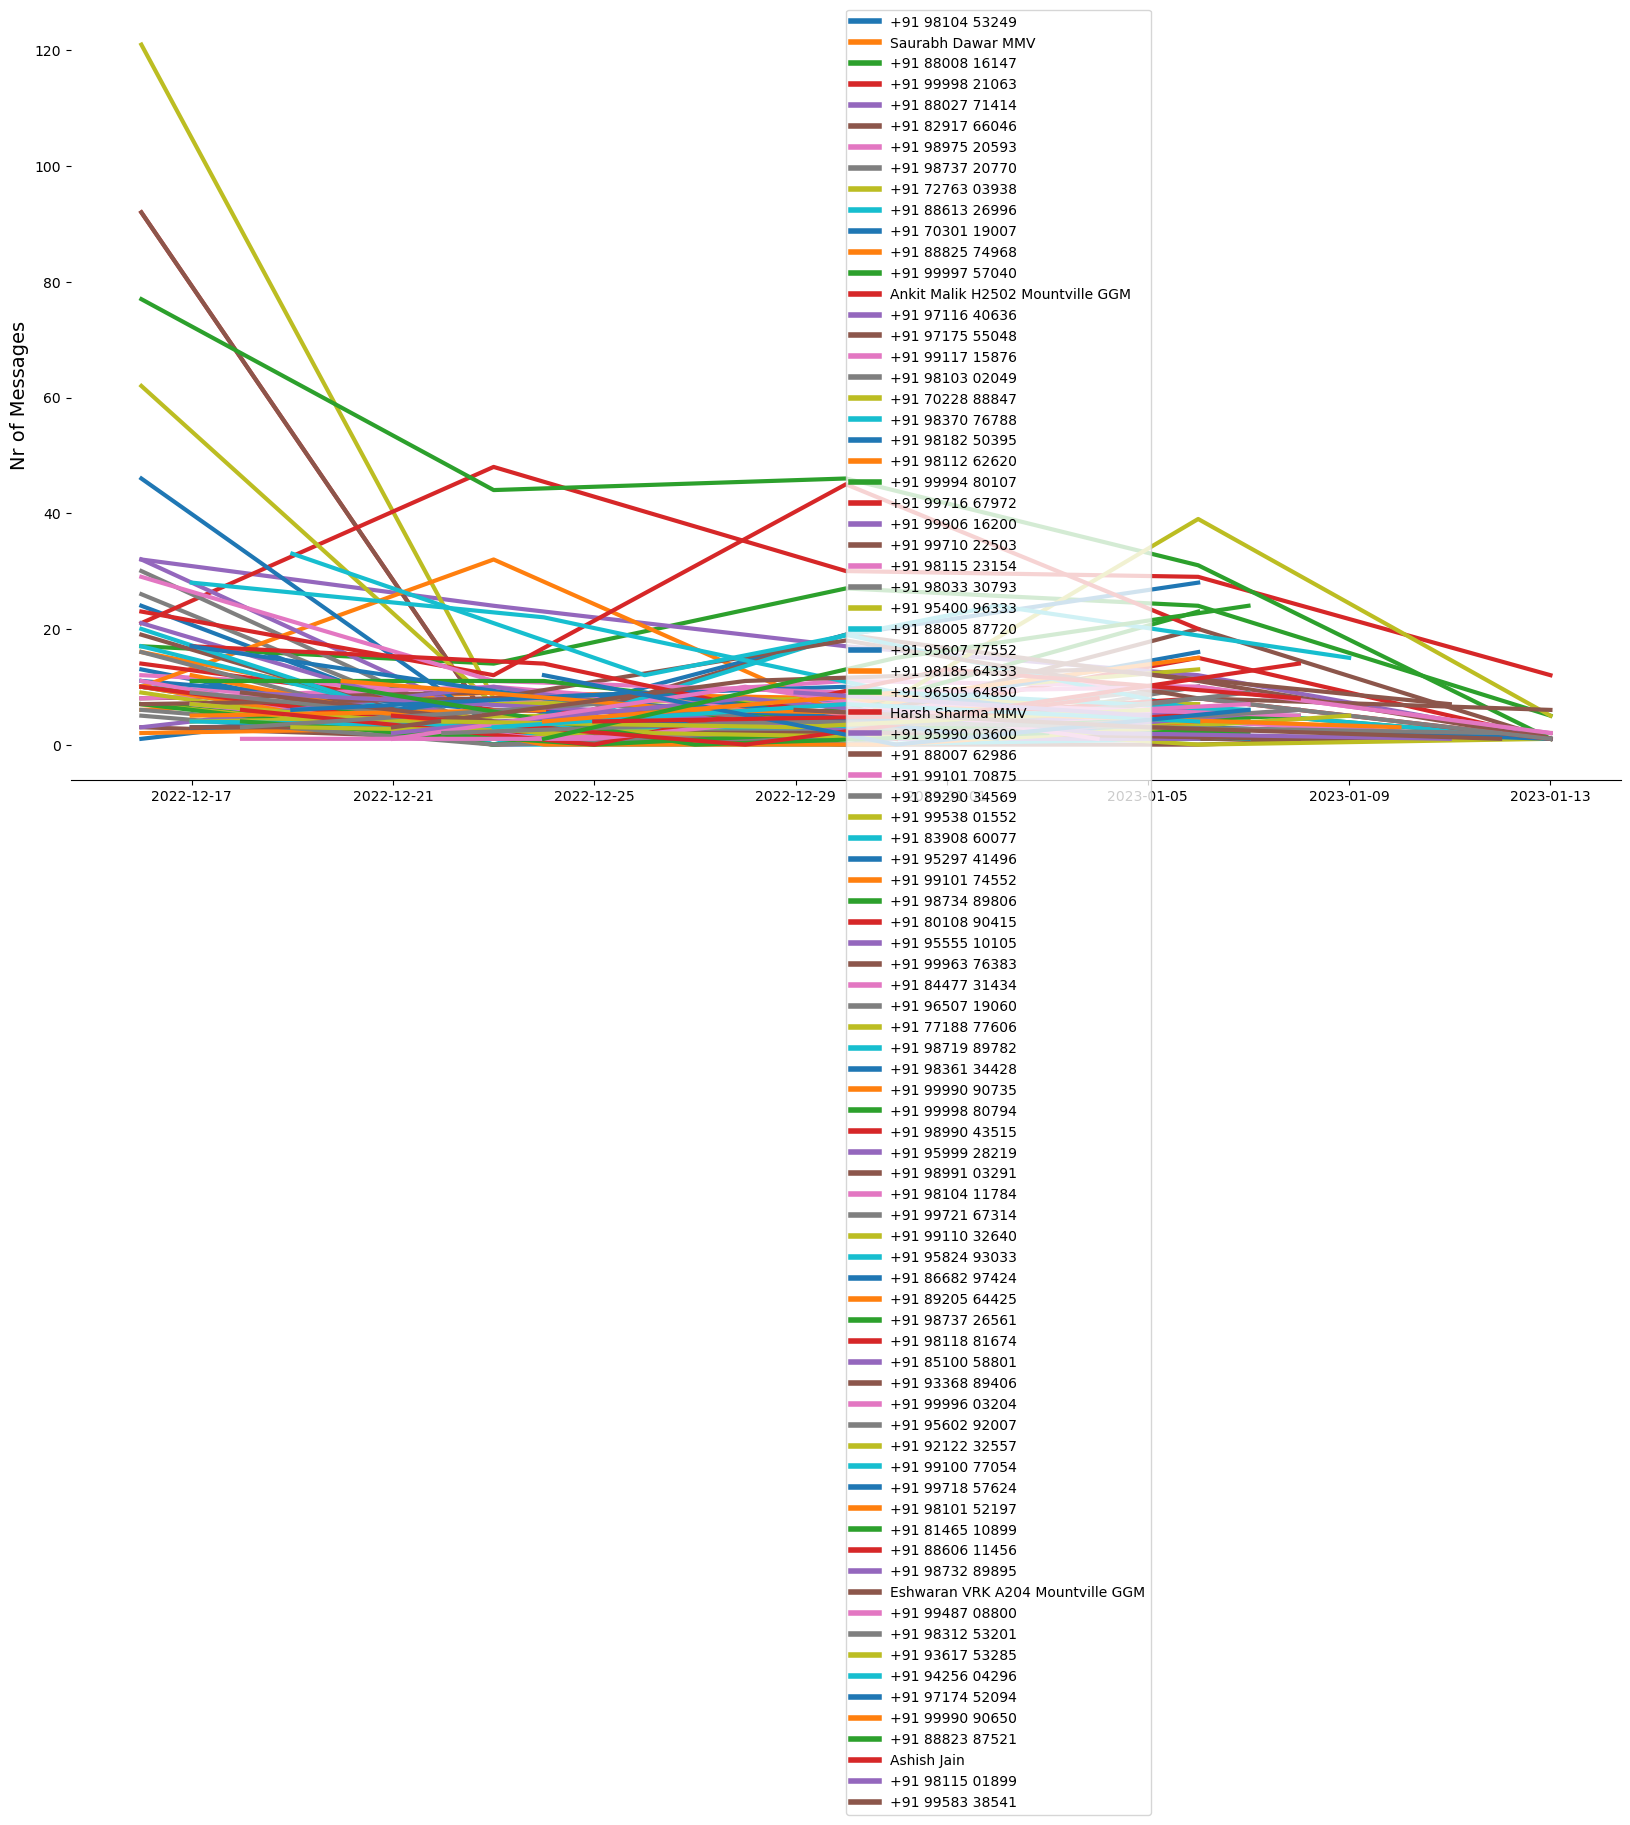

In [38]:
general.plot_messages(df[df.Date > parse('1-Dec-2019')], colors=None, trendline=False, savefig=False, dpi=100)

ConversionError: Failed to convert value(s) to axis units: ['Jan \n2023', 'Dec \n2022']

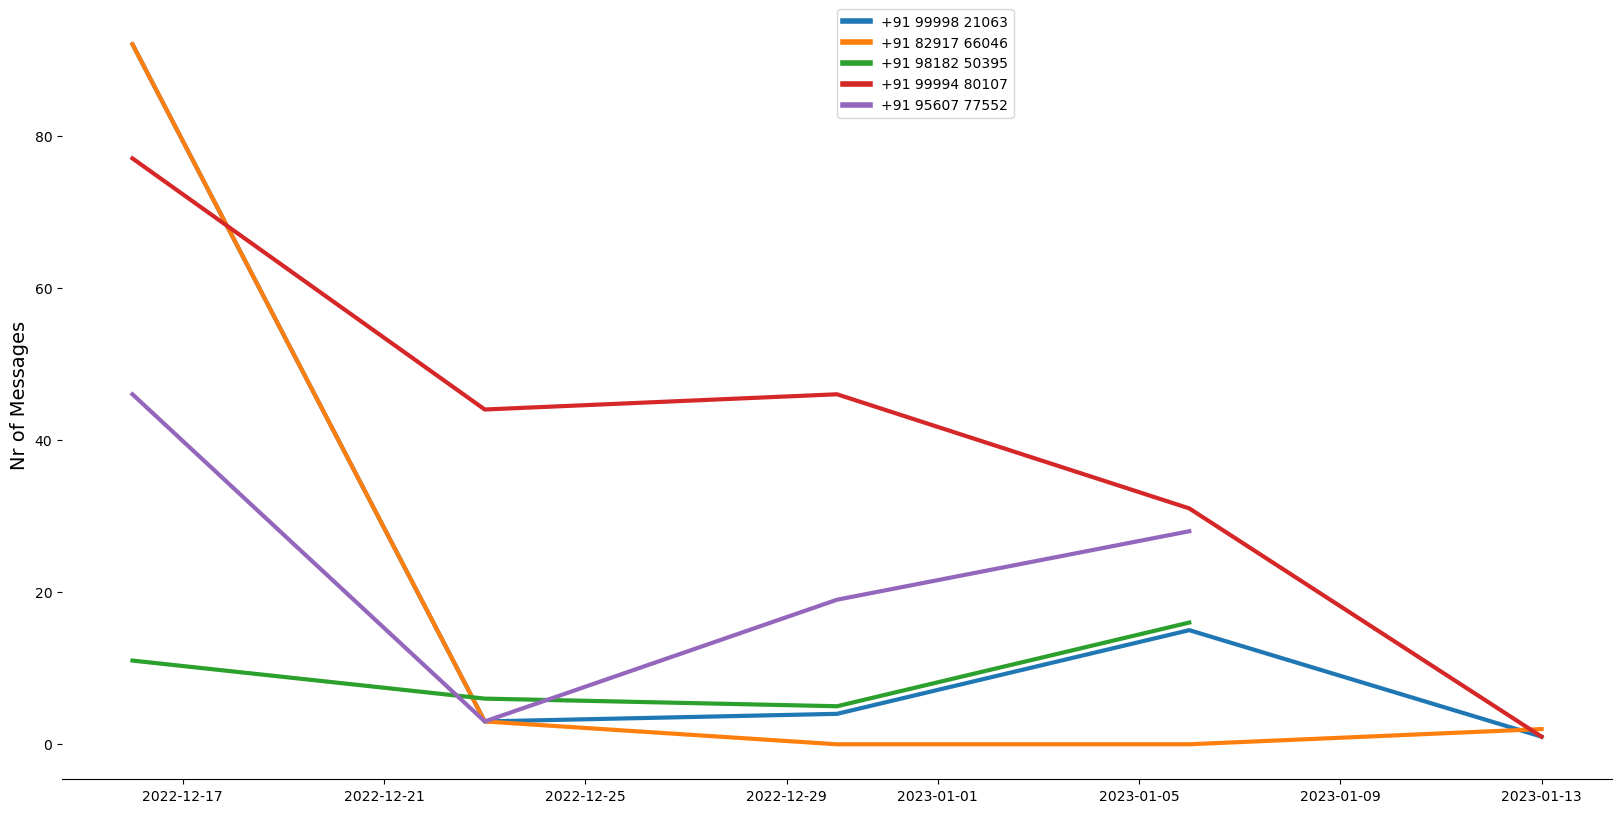

In [40]:
general.plot_messages(df[df.User.isin(u[0:5]) & (df.Date > parse('1-Nov-2019'))], colors=None, trendline=False, savefig=False, dpi=100)

#### <a name="gs-active">2.4 Active Moments</a> 
[Back to Table of Contents](#table)

**Daily Activity**  
This shows the daily activity per person in a spider plot and in total in a histogram. 
NOTE: This is unstandardized data, which means that it also shows the amount of messages. 

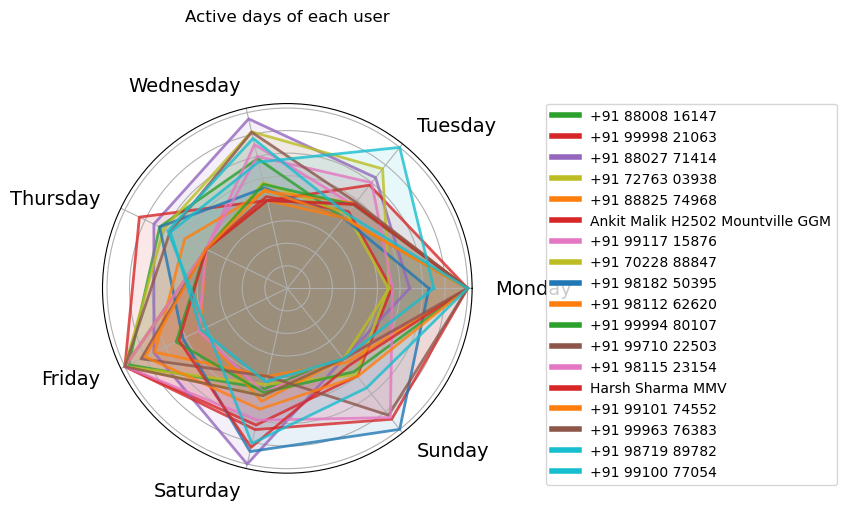

In [41]:
general.plot_day_spider(df, colors=None, savefig=False, dpi=100)

# The spider plot is not giving the expected results.

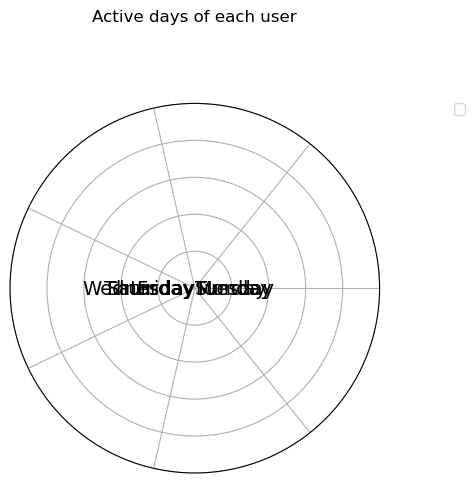

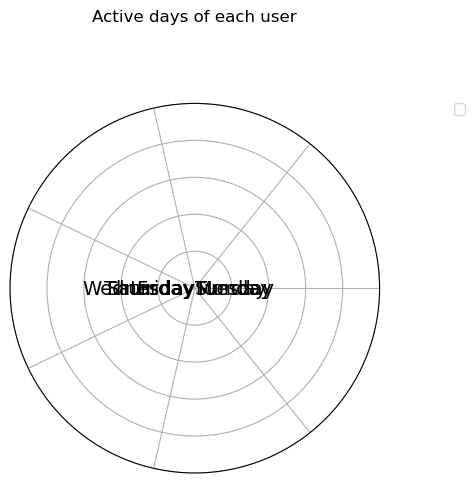

In [42]:
for i in ['Shital Karhade', 'Shambhavi Choudhary']:
    general.plot_day_spider(df[df['User'] == i], colors=None, savefig=False, dpi=100)

In [43]:
Day_of_Week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in set(df.User.tolist()):
    temp = df[df.User == i].groupby('Day_of_Week').count()['index'].to_frame().reset_index()
    temp.columns = ['Day_of_Week', 'msgs_sent']
    print(i + ": " + Day_of_Week[temp[temp.msgs_sent == temp.msgs_sent.max()].iloc[0]['Day_of_Week']]
          + ": " + str(temp[temp.msgs_sent == temp.msgs_sent.max()].iloc[0]['msgs_sent']))
    

+91 95824 93033: Saturday: 6
+91 89290 34569: Friday: 8
+91 82917 66046: Friday: 69
+91 99110 32640: Thursday: 5
+91 70228 88847: Friday: 24
+91 99117 15876: Monday: 12
+91 99101 74552: Monday: 9
+91 98103 02049: Friday: 22
+91 98990 43515: Wednesday: 10
+91 98991 03291: Monday: 3
+91 70301 19007: Friday: 13
+91 98370 76788: Sunday: 5
Harsh Sharma MMV: Monday: 28
+91 98737 20770: Friday: 19
+91 88823 87521: Sunday: 13
+91 98104 53249: Friday: 26
+91 98361 34428: Friday: 4
+91 99538 01552: Friday: 10
+91 98115 01899: Thursday: 7
+91 99906 16200: Friday: 31
+91 99990 90735: Saturday: 12
+91 95999 28219: Tuesday: 6
+91 88825 74968: Monday: 15
Ashish Jain: Friday: 13
+91 77188 77606: Friday: 10
+91 93617 53285: Thursday: 7
+91 88007 62986: Saturday: 18
+91 92122 32557: Monday: 3
+91 98312 53201: Friday: 3
+91 99998 80794: Saturday: 11
Ankit Malik H2502 Mountville GGM: Monday: 29
+91 97116 40636: Monday: 7
+91 99710 22503: Monday: 12
+91 99996 03204: Monday: 7
+91 99487 08800: Wednesday: 7


In [44]:
Day_of_Week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [45]:
for i in ['Shital Karhade', 'Shambhavi Choudhary']:
    print(i, ":")
    print(df[df.User == i].groupby('Day_of_Week').count()['index'].to_frame().reset_index())

Shital Karhade :
Empty DataFrame
Columns: [Day_of_Week, index]
Index: []
Shambhavi Choudhary :
Empty DataFrame
Columns: [Day_of_Week, index]
Index: []


In [46]:
Counter(df[df.User == "Shambhavi Choudhary"]['Day_of_Week'])

Counter()

findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


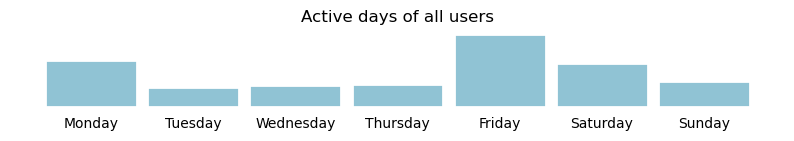

In [47]:
general.plot_active_days(df, savefig=False, dpi=100)

ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of ticklabels (7).

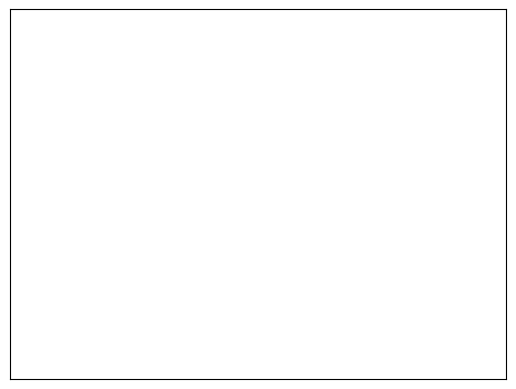

In [48]:
for i in ['Shital Karhade', 'Shambhavi Choudhary']:
    general.plot_active_days(df, savefig=False, dpi=100, user = i)

**Hourly Activity**  
It shows which days are most active based on the period in which most messages are send. 

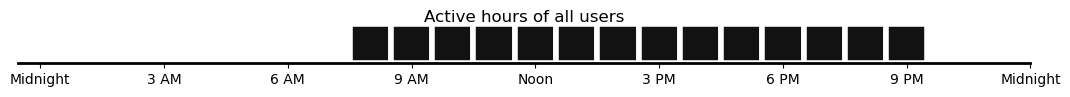

In [49]:
general.plot_active_hours(df, color='#121212', savefig=False, dpi=100, user='All')

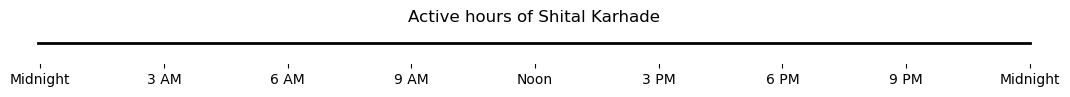

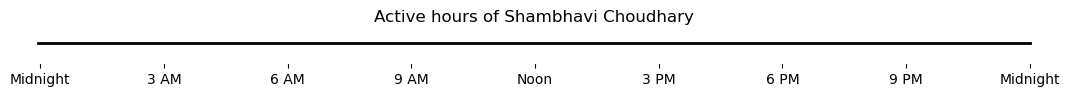

In [50]:
for i in ['Shital Karhade', 'Shambhavi Choudhary']:
    general.plot_active_hours(df, color='#121212', savefig=False, dpi=100, user = i)

**Calendar Map**  
Here you can choose for which year you want to see the activity

/home/ashish/Desktop/ws/gh/public/pubML/e10_whatsapp_soan/soan_master/whatsapp/general.py:599: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  'week': daily.index.week})


KeyError: datetime.date(2022, 1, 15)

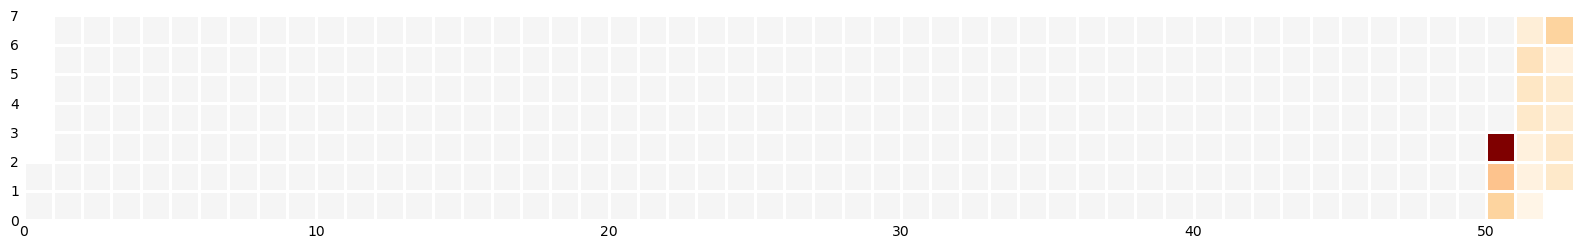

In [51]:
# Need to set the index and provide a single column
general.calendar_plot(df, year=2022, how='count', column='index')

/home/ashish/Desktop/ws/gh/public/pubML/e10_whatsapp_soan/soan_master/whatsapp/general.py:599: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  'week': daily.index.week})


KeyError: datetime.date(2020, 1, 15)

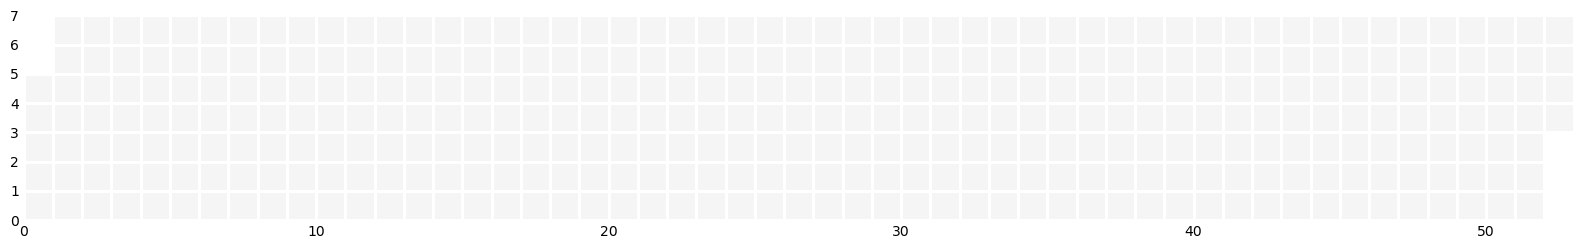

In [52]:
general.calendar_plot(df, year=2020, how='count', column='index')

#### <a name="gs-averages">2.5 Averages / Summaries</a> 

Here you can find general averages and summaries. For those that are interested how often a person said "I love you", you can also find that. 

In [53]:
#general.print_stats(df, love=True)
# NR / Nr / nr: implies "number"

In [54]:
for i in ['Shital Karhade', 'Shambhavi Choudhary']:
    general.print_stats(df[df['User'] == i], love=True)
# NR / Nr / nr: implies "number"

##########################
##  Number of Messages  ##
##########################


#######################
##  Number of Words  ##
#######################


#########################
##  Messages per hour  ##
#########################




ValueError: Expected a 1D array, got an array with shape (0, 14)

#### <a name="gs-response">2.6 Response Time</a> 

**keep_order = True** maintains the order of messages in the dataframe which is neccesary in order to calculate the response time between messages. However, it is more time-consuming which is why I created a separate function for this. 

In [ ]:
# df.sort_values('Date', inplace=True)
general.print_timing(df)

## <a name="tfidf">3. TF-IDF</a> 

#### <a name="tf-count">3.1 Create Count Vector</a> 

It creates the dataframe "counts" which is a dataframe that contains each word that is said in all conversations and counts how often each user has said that word. 

In [55]:
# Shambhavi Choudhary
counts = tf_idf.count_words_per_user(df[df["User"] == "Shital Karhade"], sentence_column="Message_Only_Text", user_column="User")
counts = tf_idf.remove_stopwords(counts, column="Word")

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/home/ashish/nltk_data'
    - '/home/ashish/anaconda3/nltk_data'
    - '/home/ashish/anaconda3/share/nltk_data'
    - '/home/ashish/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


#### <a name="tf-unique">3.2 Unique Words</a> 

Below you can see three version of TF-IDF that I created. After much experimentation it turns out that they are all quite similar and that Version C gives me a nice distribution of values needed for the plotting. Content-wise they all have a very similar meaning. 

**Version A - Messages**  
  
$TFIDF_i = \frac{{t_{ij}+1}^2}{\sum_{i=1}^{n} t_j} \times \frac{\sum_{i=1}^{n} m_i}{m_i} $  
  
$t_{ij} = $ Number of times word $j$ said by $i$   
$m_i = $ Number of messages texted by $i$  
  

**Version B - Words**

$TFIDF_i = \frac{{t_{ij}+1}^2}{\sum_{i=1}^{n} t_j} \times \frac{\sum_{i=1}^{n} w_i}{w_i}$

$t_{ij} = $ Number of times a specific word $j$ was said by $i$  
$w_i = $ Number of words texted by $i$


**Version C - Adjusted TF-IDF**

$ TFIDF_i = \frac{{t_{ij} + 1}}{w_i + 1} \times \log{\frac{m}{\sum_{i=1}^{n} t_j}} $  
$w_i = $ Number of words texted by $i$  
$t_{ij} = $ Number of times a specific word $j$ was said by $i$  
$m = $ Number of all messages   

** Unique Words **  
  
$ Unique_i = \frac{TFIDF_i}{\sum\limits_{j, j \neq i}^n TFIDF_i} $


In [56]:
# Shambhavi Choudhary
unique_words = tf_idf.get_unique_words(counts, df[df["User"] == "Shital Karhade"], version = 'C')

#### <a name="tf-image">3.3 Plot Image</a> 

This is where things got a bit tricky...

I created a horizontal bar chart with two bars stacked on top of each other both plotted on a background image. I started with a background image and plotted the actual values on the left and made it fully transparent with a white border to separate the bars. Then, on top of that I plotted which bars so that the right part of the image would get removed. 

In [57]:
# tf_idf.print_users(df)

**Instructions**  
Make sure to change "user" in the function below to one of the users as seen above. It needs to be the exact same naming otherwise it will not work. Furthermore, a valid picture needs to be selected. You can choose the sizing yourself which might need some experimenting with before finding the right size. It also works with a link to the image online. 

In [58]:
%%time
importlib.reload(tf_idf)
ul0 = ['Ashish Jain']
ul1 = ['Shital Karhade', 'Shambhavi Choudhary']
ul2 = ['Ashish Jain', 'Shital Karhade', 'Shambhavi Choudhary'] # 2min 20s
ul3 = set(df.User.values) # Takes infinite time to run
ul4 = ['Salil Bansal', 'Divjot Singh'] # 3min 54s
ul = ul4

for username in ul:
    counts = tf_idf.count_words_per_user(df[df["User"].isin(ul)], sentence_column="Message_Only_Text", user_column="User")
    counts = tf_idf.remove_stopwords(counts, column="Word", path_to_stop_words = "E:/Workspace/Jupyter/e2_whatsapp_soan/soan_master/whatsapp")
    
    unique_words = tf_idf.get_unique_words(counts, df[df["User"].isin(ul)], version = 'C')
    tf_idf.plot_unique_words(unique_words, user = username, image_path='histogram.jpg', image_url=None, 
                             title = username, title_color="white", 
                             title_background='#AAAAAA', width=400, height=500)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/home/ashish/nltk_data'
    - '/home/ashish/anaconda3/nltk_data'
    - '/home/ashish/anaconda3/share/nltk_data'
    - '/home/ashish/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


## <a name="emoji">4. Emoji Analysis</a> 

These analysis are based on the Emojis used in each message. Below you can find the following:
* Unique Emoji per user
* Commonly used Emoji per user
* Highly correlated Emoji per user

#### <a name="emoji-prepare">4.1 Prepare Data</a> 
[Back to Table of Contents](#table)

The data needs to be prepared as follows:
* Three new columns are created:
    * *Emoji* contains all emojis in a message
    * *Emoji_Counts* counts the number of emojis in a message
    * *Different_Emojis* extracts them in a list for handling purposes
* *counts* is a dictionary of dictionaries containing the count of each emoji per user
* *unique_emoji* is a dict of dicts containing a uniqueness score of each emoji per user compared to other users

In [59]:
def init_emojis_data(users):
    if len(users) > 20:
        print("Number of users passed as input should be less than or equal to 20.")
        return 0, 0
    temp = df[df.User.isin(users)][['index', 'Message_Raw', 'User', 'Message_Clean', 'Message_Only_Text']].copy()
    temp = soan_emoji.prepare_data(temp)

    # Count all emojis
    counts = soan_emoji.count_emojis(temp, non_unicode=True)

    # Get unique emojis
    list_of_words = [word for user in counts for word in counts[user]]
    unique_emoji = soan_emoji.get_unique_emojis(temp, counts, list_of_words)
    return counts, list_of_words, unique_emoji

counts, list_of_words, unique_emoji = init_emojis_data(users = ['Ashish Jain', 'Shital Karhade'])

AttributeError: module 'emoji' has no attribute 'UNICODE_EMOJI'

#### <a name="emoji-stats">4.2 Unique and Common Emoji</a> 
[Back to Table of Contents](#table)

Below you can find the most unique emojis according to the TF-IDF and Unique formulas that were used previously: 

** TF-IDF **

$ TFIDF_i = \frac{{t_{ij} + 1}}{w_i + 1} \times \log{\frac{m}{\sum_{i=1}^{n} t_j}} $  
$w_i = $ Number of words texted by $i$  
$t_{ij} = $ Number of times a specific emoji $j$ was said by $i$  
$m = $ Number of all messages  

** Unique Emoji **  
  
$ Unique_i = \frac{TFIDF_i}{\sum\limits_{j, j \neq i}^n TFIDF_i} $

I purposefully based it on the number of words and messages in total and only changed *t* to the number of times emoji was said

In [ ]:
soan_emoji.print_stats(unique_emoji, counts)

In [ ]:
ul = set(df.User.values)
ul = ['Ashish Jain', 'Shital Karhade']
for username in ul:
    soan_emoji.plot_counts(counts, user = username)

#### <a name="emoji-corr">4.3 Correlation Matrix</a> 

Below you find a correlation matrix of the 15 most often used emoji by a single user. The reasoning for only taking 15 emojis is that otherwise the matrix simply becomes too big. 

In [60]:
importlib.reload(soan_emoji)
ul = set(df.User.values)
ul = ['Ashish Jain', 'Shital Karhade']
for username in ul:
    print(username)
    try:
        counts, list_of_words, unique_emoji = init_emojis_data(users = [username])
        corr = soan_emoji.plot_corr_matrix(df, username, list_of_words, counts)
    except:
        print("In 'except'.")

Ashish Jain
In 'except'.
Shital Karhade
In 'except'.


In [61]:
counts, list_of_words, unique_emoji = init_emojis_data(users = ['Ashish Jain'])

AttributeError: module 'emoji' has no attribute 'UNICODE_EMOJI'

In [ ]:
list_of_words

In [ ]:
counts

In [ ]:
importlib.reload(soan_emoji)
corr = soan_emoji.plot_corr_matrix(df, 'Ashish Jain', list_of_words, counts)

## <a name="topic">5. Topic Modelling</a> 
[Back to Table of Contents](#table)

#### <a name="topic-prepare">5.1 Prepare Data</a> 
[Back to Table of Contents](#table)

The data is prepared as follows:
The *pattern* is used as that is one of the few (sort of) working Dutch NLP-processors for python. There is generally little available with regards to Dutch processors. Since I want to extract topics translating text did not seem like the right way to go. So, using *pattern* I used the following functions where necessary:
* Lemmatization
* Singularize
* Predicative

Unfortunately, stemming was not an option since the Snowball stemmer from NLTK makes too many mistakes to be used. 

*NOTE*: These analyses are for the purpose of getting insights into whatsapp data. I did not spend much time optimizing algorithms for the simple reason that they already give good results out-of-the-box. Moreover, optimizing my results is likely not generalizable to your data as you are quick to overfit with such limited data.

*NOTE2*: # Make sure to download the version for python 3+:
* https://github.com/clips/pattern/tree/development
* git clone -b development https://github.com/clips/pattern
* cd pattern
* python setup.py install

In [ ]:
df['Message_Prepared'] = df.apply(lambda row: topic.prepare_text_nl(row), 1)

#### <a name="topic-lda">5.2 LDA </a> 
[Back to Table of Contents](#table)

There is an abundance of methods with regards to topic modelling. Two, however, seem to be the most used: LDA and NMF. Sklearn has an implementation of both LDA and NMF which is why I used that. It should be noted that Gensim is also an extremely good package when it comes to NLP. I will be using Gensim later below for a different application. 

In [ ]:
topic.topics(df, model='lda', stopwords='stopwords_dutch.txt')

#### <a name="topic-nmf">5.3 NMF </a> 
[Back to Table of Contents](#table)

An application of the NMF model used for topic modelling. 

In [ ]:
topic.topics(df, model='nmf', stopwords='stopwords_dutch.txt')

## <a name="sentiment">6. Sentiment</a> 
[Back to Table of Contents](#table)

#### <a name="sentiment-prepare">6.1 Prepare Data</a> 
[Back to Table of Contents](#table)

Fortunately, in order to extract sentiment from a Dutch message you can extract the score (-1 being negative and 1 being positive) easily using the pattern package. Below I extract the sentiment as a new column which is needed for further analysis. 

In [ ]:
from pattern.nl import sentiment  as sentiment_nl
df['Sentiment'] = df.apply(lambda row: sentiment_nl(row.Message_Clean)[0], 1)

#### <a name="sentiment-average">6.2 Average Sentiment Per User</a> 
[Back to Table of Contents](#table)

Prints the average sentiment per user to get an indication of positivity of that user. 

*NOTE*: THIS ONLY WORKS FOR DUTCH!

In [62]:
sentiment.print_avg_sentiment(df)

			#######################
			## Average Sentiment ##
			#######################


KeyError: 'Sentiment'

#### <a name="sentiment-plot">6.3 Plot Sentiment</a> 
[Back to Table of Contents](#table)

Below you can see a plot of how positive the messages are over time. The y-axis works as follows, a happy smiley indicates a score of 1 (max value) meaning a positive message and a sad smiley indicates a score of -1 (min value) meaning a negative message. 

In [ ]:
colors_list_2  = ['#EAAA69','#5361A5']
colors_list_8  = ['#EAAA69','#5361A5', '#000000', '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#00ffff']

num_of_colors = len(set(df.User.values))
colors_list = []
for i in range(100000, num_of_colors):
    colors_list += ['#' + str(hex(i))[2:]]
    
sentiment.plot_sentiment(df, colors=colors_list, savefig=False)

## <a name="cloud">7. Word Clouds</a> 
[Back to Table of Contents](#table)

#### <a name="cloud-prepare">7.1 Prepare Data</a> 
[Back to Table of Contents](#table)

In [ ]:
# Counts words and create dictionary of words with counts
counts = tf_idf.count_words_per_user(df,sentence_column="Message_Only_Text",user_column="User")
counts = tf_idf.remove_stopwords(counts, column="Word")

#### <a name="cloud-mask">7.2 Masked Word Cloud</a> 
[Back to Table of Contents](#table)

In [ ]:
soan_wordcloud.create_wordcloud(df.Message_Only_Text, # mask = 'mask.jpg', 
                           stopwords='stopwords_dutch.txt', random_state=42, 
                           max_words=1000, max_font_size=50, scale=2, 
                           normalize_plurals=False, relative_scaling = 0.5)

#### <a name="cloud-sentiment">7.3 Sentiment-based Word Cloud</a> 
[Back to Table of Contents](#table)

*NOTE*: ONLY WORKS FOR DUTCH

In [ ]:
# Choose which user you want to see the word cloud for

for username in set(df.User.values):
    positive, negative = soan_wordcloud.extract_sentiment_count(counts, user = username)

##### Positive Words

In [ ]:
soan_wordcloud.create_wordcloud(data=positive, cmap='Greens', # mask='mask.jpg', 
                    stopwords='stopwords_dutch.txt', random_state=42, max_words=1000, 
                    max_font_size=50, scale=1.5, normalize_plurals=False, relative_scaling=0.5)

##### Negative Words

In [ ]:
soan_wordcloud.create_wordcloud(data=negative, cmap='Reds', #mask='mask.jpg', 
                    stopwords='stopwords_dutch.txt', random_state=42, max_words=1000, 
                    max_font_size=50, scale=1.5, normalize_plurals=False, relative_scaling=0.5)

## <a name="color">8. Picture Analysis</a> 
[Back to Table of Contents](#table)

NOTE: This is not part of the whatsapp data. For this chapter to work, you'll need to put at least 1 image in the folder 'Images/' or create a path of your own. It is set to not run automatically since this is merely an extra feature. Set run_colors to True if you want to run the script. 

#### <a name="color-get">8.1 Extract Frequent Colors (k-Means)</a> 
[Back to Table of Contents](#table)

In [63]:
import os
import pickle

Below is the code to retrieve and dump the top 5 most frequent colors in an image using k-Means. 
It works as follows, each pixel in an image has its own color. That color of each pixel in an image is then extracted in an rgb format. This allows each pixel to have an x (r), y (g) and z (b) coordinate. After extracting all colors of each pixel, k-Means (with k=5) is then used to cluster the points into 5 colors. For each cluster the mediod is calculated and used as a representative of that cluster. Thus, you get top 5 colors for each image. 

In [64]:
extract_colors = False

if extract_colors:
    # Get Top 5 Frequent Colors
    path = 'Images/'
    all_colors = [colors.get_common_colors(path + i) for i in os.listdir(path)]

    # Save colors
    with open('colors.pkl', 'wb') as f:
        pickle.dump(all_colors, f)

#### <a name="color-plot">8.2 Plot Frequent Colors</a> 
[Back to Table of Contents](#table)

After getting the top 5 colors for each picture, they are counted and then displayed below in a histogram. The histogram is in a circular shape where larger/bigger/higher bars indicate colors that are more frequent in the set of pictures. There is a version of the histogram that only shows bars and one that shows a smoothened histogram to be more visually pleasing. 

In [46]:
colors.plot_color('colors.pkl', smoothen=False, savefig=False)

AttributeError: 'list' object has no attribute 'plot_color'

In [47]:
colors.plot_color('colors.pkl', smoothen=True, savefig=False)

AttributeError: 'list' object has no attribute 'plot_color'